In [1]:
from wavlm import wavlm_large
from hifigan import hifigan_wavlm
from knn import KNeighborsVC, knn_vc
from tqdm import tqdm

from hallucinator.data import VCTKDataset, HallucinatorSetDataset
from hallucinator import SetDDPM, cosine_beta_schedule
import torch
from torch.utils.data import Subset
from torch.nested import nested_tensor
import random
from utils import wavlm_embedding, wavlm_func_gen
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
wavlm_model = wavlm_large()
wavlm_model.eval()
for param in wavlm_model.parameters():
    param.requires_grad = False
        
wavlm_model = torch.compile(wavlm_model)
    
vctk_dat = VCTKDataset(root_dir="hallucinator/dataset/VCTK-Corpus", wavlm_fn=wavlm_embedding, wavlm=wavlm_model, device=torch.device("cuda"))
# print(len(vctk_dat))
    
# min = 29 max = 963 seqs
    

WavLM-Large loaded with 315,453,120 parameters.
Loaded 44242 audio files from 109 speakers.


In [3]:
hallu_dat = HallucinatorSetDataset(None, hall_dataset_path="hallucinator/dataset/Hallu-Corpus", exists_hall_dataset=True)
    
set_ddpm = SetDDPM(
    T_timesteps=255,
    schedule=cosine_beta_schedule,
    device=torch.device("cuda")
)

# set_ddpm.sample_batch(1, [200], nested_tensor([dct['total_speech_set']]), nested_tensor([dct['mask']]))

In [4]:
train_hallu_dat = Subset(hallu_dat, random.sample(range(len(hallu_dat)), 5_000))

In [5]:
train_loss, val_1, val_2 = set_ddpm.train(10, train_hallu_dat, batch_size=32, model_save_path="hallucinator/checkpoints/test_1_hallu.pt")

epoch: 0


sampling loop time step: 100%|██████████| 255/255 [01:28<00:00,  2.89it/s]


epoch: 1


100%|██████████| 155/155 [05:39<00:00,  2.19s/it]


epoch: 2


100%|██████████| 155/155 [05:23<00:00,  2.09s/it]


epoch: 3


100%|██████████| 155/155 [04:00<00:00,  1.55s/it]


epoch: 4


100%|██████████| 155/155 [03:59<00:00,  1.55s/it]


epoch: 5


sampling loop time step: 100%|██████████| 255/255 [01:18<00:00,  3.24it/s]


epoch: 6


100%|██████████| 155/155 [04:00<00:00,  1.55s/it]


epoch: 7


100%|██████████| 155/155 [03:59<00:00,  1.54s/it]


epoch: 8


100%|██████████| 155/155 [04:00<00:00,  1.55s/it]


epoch: 9


100%|██████████| 155/155 [04:00<00:00,  1.55s/it]


Text(0, 0.5, 'Loss')

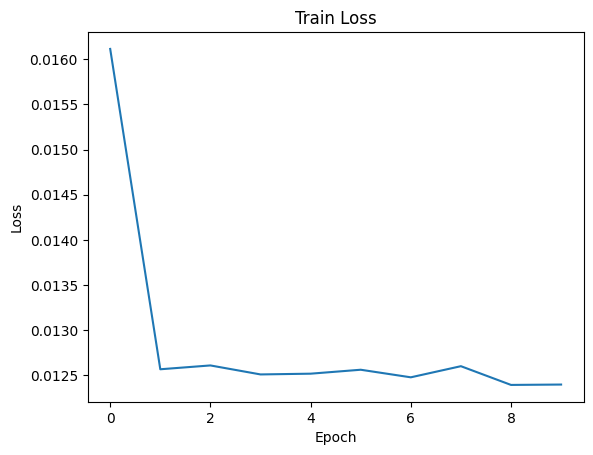

In [6]:
# plot trainloss
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")


Text(0, 0.5, 'Loss')

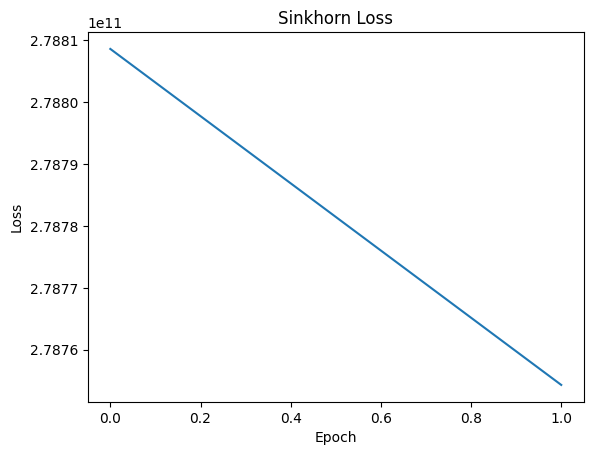

In [12]:
#plot val_1
plt.plot(val_1)
plt.title("Sinkhorn Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")



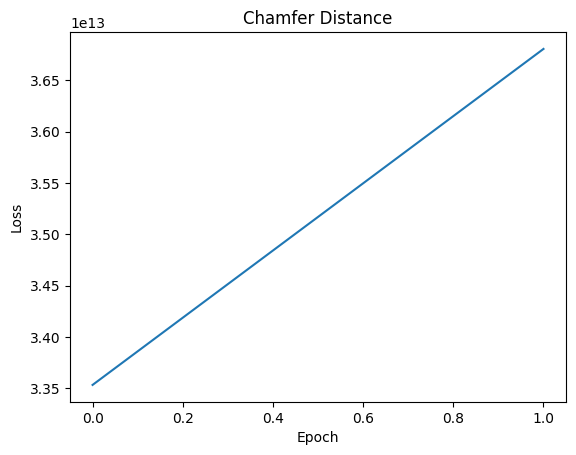

In [10]:
plt.plot(val_2)
plt.title("Chamfer Distance")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()